In [160]:
import numpy as np
import pandas as pd
import os
from os import listdir
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import imutils

from tensorflow.keras.models import Model,load_model
from tensorflow.keras.layers import Conv2D,Input,ZeroPadding2D,BatchNormalization,Flatten,Activation,Dense,MaxPooling2D
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle #shuffling the data improves the model

In [162]:
image_dir=r"C:\brain dataset\no\no 1"

In [164]:
os.makedirs('augmented-images')
os.makedirs('augmented-images/training')
os.makedirs('augmented-images/testing')

os.makedirs('augmented-images/training/no')
os.makedirs('augmented-images/training/yes')


os.makedirs('augmented-images/testing/no')
os.makedirs('augmented-images/testing/yes')

FileExistsError: [WinError 183] Cannot create a file when that file already exists: 'augmented-images'

Augmentation of images


In [167]:
import cv2
import os
from os import listdir
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def augment_data(file_dir, n_generated_samples, save_to_dir):
    if not os.path.exists(save_to_dir):
        os.makedirs(save_to_dir)
        
    data_gen = ImageDataGenerator(rotation_range=10,
                                  width_shift_range=0.1,
                                  height_shift_range=0.1,
                                  shear_range=0.1,
                                  brightness_range=(0.3, 1.0),
                                  horizontal_flip=True,
                                  vertical_flip=True,
                                  fill_mode='nearest'
                                 )

    for filename in listdir(file_dir):
        image_path = os.path.join(file_dir, filename)
        if os.path.isfile(image_path):
            image = cv2.imread(image_path)
            if image is not None:
                # reshape the image
                image = image.reshape((1,)+image.shape)
                save_prefix = 'aug_' + filename[:-4]
                i=0
                for batch in data_gen.flow(x=image, batch_size=1, save_to_dir=save_to_dir,save_prefix=save_prefix, save_format='jpg'):
                    i += 1
                    if i > n_generated_samples:
                        break
            else:
                print(f"Failed to read image: {image_path}")
        else:
            print(f"File not found: {image_path}")

In [169]:
augmented_data_path =r'augmented-images/'
image_dir="dataset/"
# augment data for the examples with label equal to 'yes' representing tumurous examples
augment_data(file_dir=image_dir+'Training/no',n_generated_samples=6, save_to_dir=augmented_data_path+'training/no')
# augment data for the examples with label equal to 'no' representing non-tumurous examples
augment_data(file_dir=image_dir+'Training/yes', n_generated_samples=9, save_to_dir=augmented_data_path+'training/yes')

Preprocessing the data
After applying the cropping function

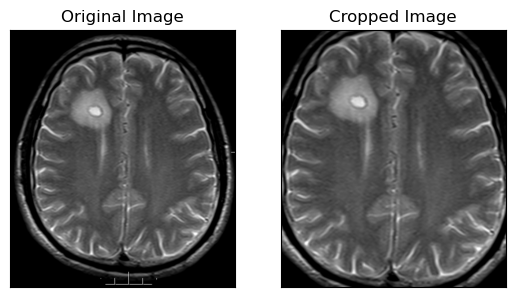

In [171]:
import cv2
import imutils
import matplotlib.pyplot as plt

def crop_brain_contour(image, plot=False):
    # Convert the image to grayscale, and blur it slightly
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # Find contours in thresholded image, then grab the largest one
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)
    # extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])

    # crop new image out of the original image using the four extreme points (left, right, top, bottom)
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]

    if plot:
        plt.figure()
        plt.subplot(1, 2, 1)
        plt.imshow(image)
        plt.tick_params(axis='both', which='both', top=False, bottom=False, left=False, right=False,labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        plt.title('Original Image')
        plt.subplot(1, 2, 2)
        plt.imshow(new_image)
        plt.tick_params(axis='both', which='both',top=False, bottom=False, left=False, right=False,labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        plt.title('Cropped Image')
        plt.show()

    return new_image

# Now you can use the function with the image file path
ex_img = cv2.imread(r'C:\brain dataset\yes\Y3.jpg')
ex_crop_img = crop_brain_contour(ex_img, True)

In [192]:
import cv2
from os import listdir
import numpy as np
from sklearn.utils import shuffle

def load_data(dir_list, image_size, batch_size=32):
    X = []
    y = []
    image_width, image_height = image_size

    for class_label, directory in enumerate(dir_list):
        filenames = listdir(directory)
        num_files = len(filenames)
        num_batches = num_files // batch_size

        for i in range(num_batches):
            batch_filenames = filenames[i*batch_size: (i+1)*batch_size]
            batch_images = []
            batch_labels = []

            for filename in batch_filenames:
                image = cv2.imread(directory+'/'+filename)
                image = crop_brain_contour(image, plot=False)  # Assuming this function is defined elsewhere
                image = cv2.resize(image, dsize=(image_width, image_height), interpolation=cv2.INTER_CUBIC)
                image = image / 255.

                batch_images.append(image)
                batch_labels.append(class_label)

            X.extend(batch_images)
            y.extend(batch_labels)

    X = np.array(X)
    y = np.array(y)

    X, y = shuffle(X, y)

    print(f'Number of examples is: {len(X)}')
    print(f'X shape is: {X.shape}')
    print(f'y shape is: {y.shape}')

    return X, y

In [194]:
dir_list = [r'C:\Users\Maaruboina Vamsi\augmented-images\testing\no', r'C:\Users\Maaruboina Vamsi\augmented-images\testing\yes']
image_size = (50, 50)  # Example image size
X, y = load_data(dir_list, image_size)

Number of examples is: 160
X shape is: (160, 50, 50, 3)
y shape is: (160,)


Visualization of data


In [197]:
dir_list = [r'C:\Users\Maaruboina Vamsi\augmented-images\testing\no', r'C:\Users\Maaruboina Vamsi\augmented-images\testing\yes']  # Make sure "yes" directory is included
image_size = (250, 250) 

x, y = load_data(dir_list, image_size)  # Assign the returned values

print(f'Number of examples is: {len(x)}') # Use the assigned x
print(f'x shape is: {x.shape}')       # Use the assigned x
print(f'y shape is: {y.shape}')       # Use the assigned y

# Visualization of data (now you can use x and y)
# ... your visualization code ...

Number of examples is: 160
X shape is: (160, 250, 250, 3)
y shape is: (160,)
Number of examples is: 160
x shape is: (160, 250, 250, 3)
y shape is: (160,)


Visualization of data

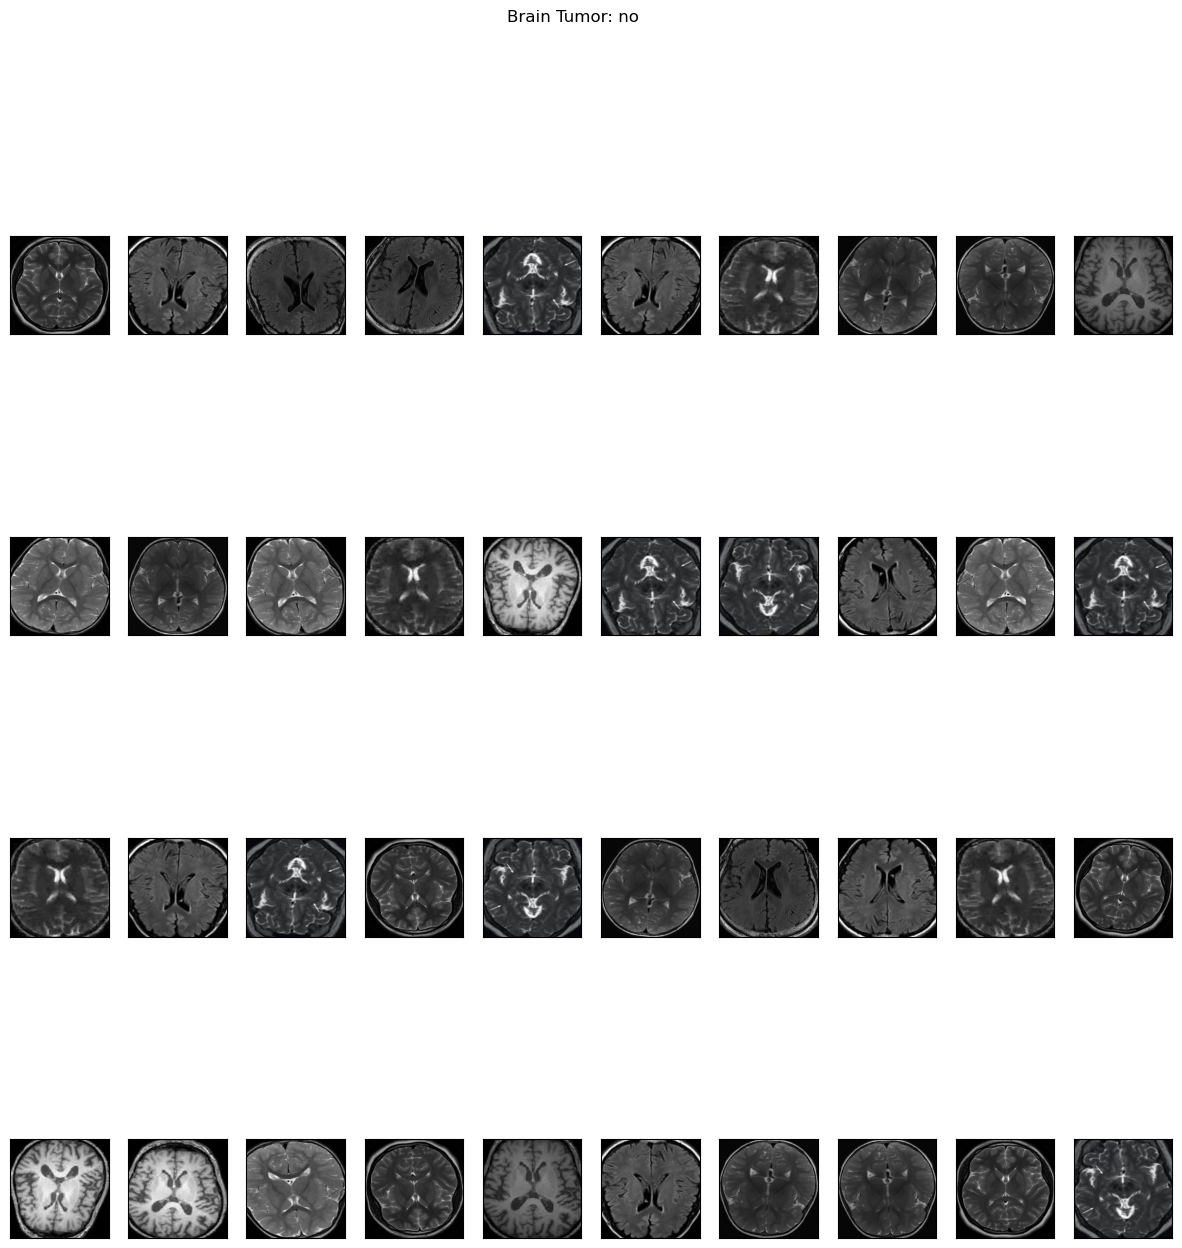

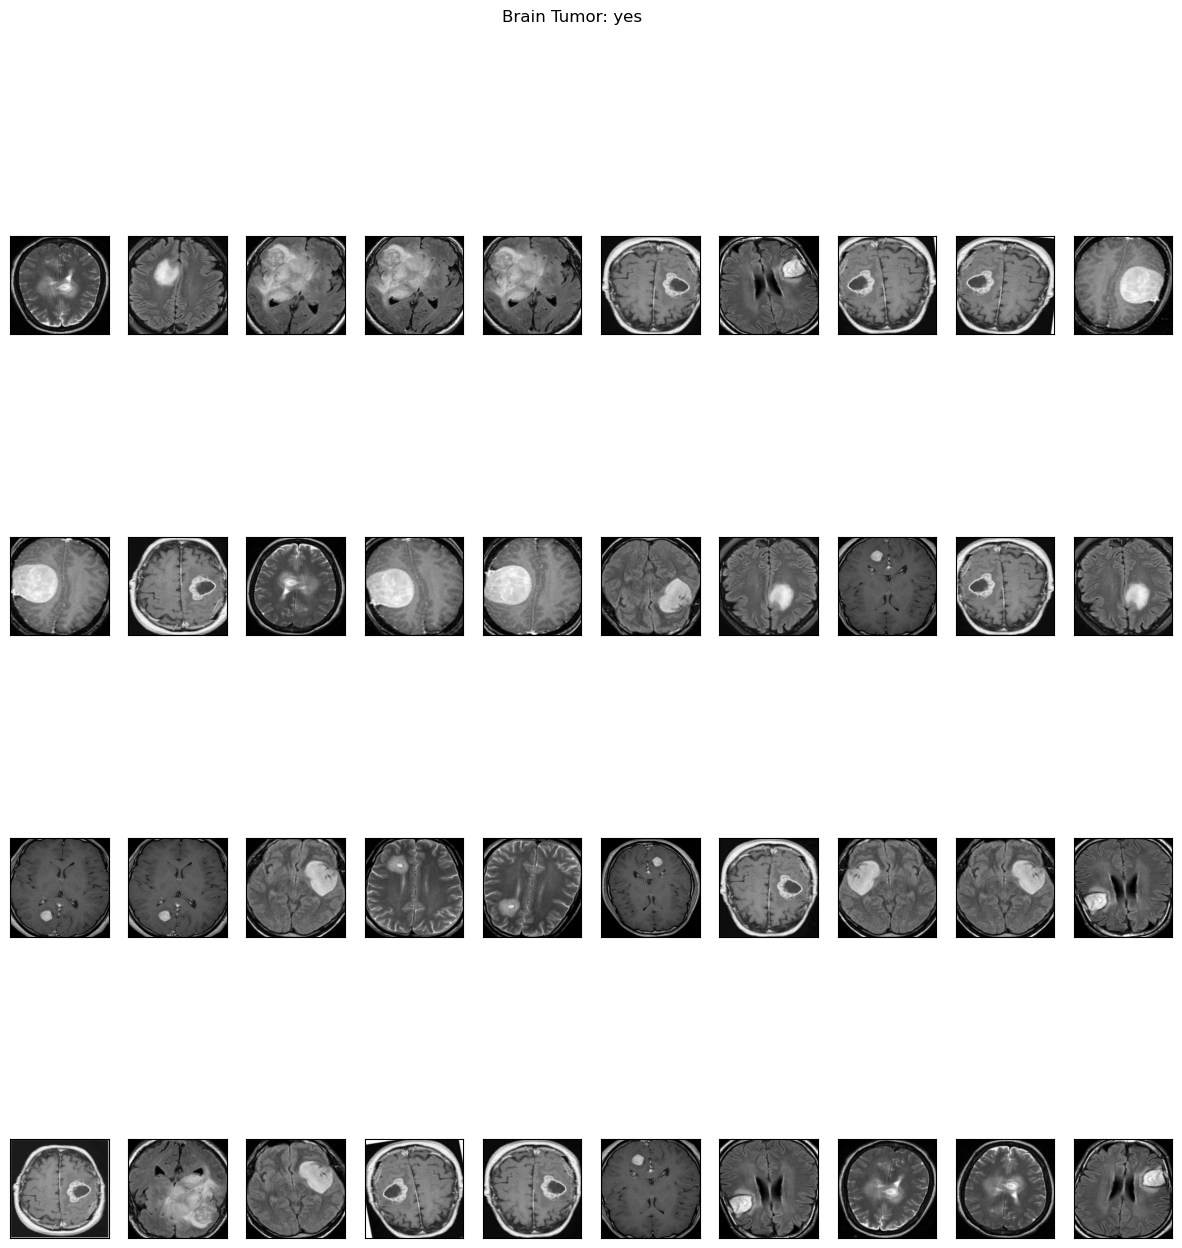

In [199]:
import numpy as np
import matplotlib.pyplot as plt

def label_to_str(label):
    return {0: "no", 1: "yes"}.get(label, "unknown")  # Handle unknown labels

def plot_sample_images(X, y, n=40):
    for label in range(2):  # Loop through the classes (0 and 1)
        indices = np.argwhere(y == label).flatten() # Get indices where y == label
        if indices.size > 0:  # Check if any images with this label exist
            images = X[indices]
            n_images = min(n, len(images))  # Adjust n if fewer images are available
            columns_n = min(10, n_images) # Adjust columns if fewer images are available
            rows_n = (n_images + columns_n - 1) // columns_n

            plt.figure(figsize=(15, 15))
            for i in range(n_images):
                plt.subplot(rows_n, columns_n, i + 1)
                plt.imshow(images[i], cmap='gray')  # Assuming grayscale images
                plt.xticks([])
                plt.yticks([])
            plt.suptitle(f"Brain Tumor: {label_to_str(label)}")
            plt.show()
        else:
            print(f"No images found for label: {label}")

# Example usage (assuming x and y are your image data and labels)
plot_sample_images(x, y)

In [201]:
def split_data(X, y, test_size=0.2):

    X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size=test_size)
    X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=0.5)

    return X_train, y_train, X_val, y_val, X_test, y_test

In [202]:
X_train, y_train, X_val, y_val, X_test, y_test = split_data(X, y, test_size=0.3)

In [203]:
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of validation examples = " + str(X_val.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))

number of training examples = 112
number of validation examples = 24
number of test examples = 24


In [204]:
def build_model(input_shape):
    X_input = Input(input_shape)
    X = ZeroPadding2D((2, 2))(X_input)

    X = Conv2D(32, (7, 7), strides=(1, 1))(X)
    X = BatchNormalization(axis=3, name='bn0')(X)
    X = Activation('relu')(X)

    X = MaxPooling2D((4, 4))(X)
    X = MaxPooling2D((4, 4))(X)

    X = Flatten()(X)
    X = Dense(128, activation='relu')(X)
    X = tf.keras.layers.Dropout(0.5)(X)  # Use tf.keras.layers.Dropout instead of Dropout

    X = Dense(4, activation='softmax')(X)

    model = Model(inputs=X_input, outputs=X)

    return model

In [205]:
IMG_WIDTH, IMG_HEIGHT = (50, 50)
IMG_SHAPE = (IMG_WIDTH, IMG_HEIGHT, 3)
model=build_model(IMG_SHAPE)
model.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 50, 50, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ zero_padding2d_1 (ZeroPadding2D)     │ (None, 54, 54, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 48, 48, 32)          │           4,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bn0 (BatchNormalization)             │ (None, 48, 48, 32)          │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 48, 48, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 12, 12, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 3, 3, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 288)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │          36,992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 42,372 (165.52 KB)

 Trainable params: 42,308 (165.27 KB)

 Non-trainable params: 64 (256.00 B)

In [206]:
# from keras.utils.vis_utils import plot_model

# plot_model(model, show_shapes=True, show_layer_names=True)

In [207]:
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of y_val: {y_val.shape}")

Shape of y_train: (112,)
Shape of y_val: (24,)


In [208]:
precision=tf.keras.metrics.Precision()
recall=tf.keras.metrics.Recall()
sensitivity=tf.keras.metrics.SensitivityAtSpecificity(0.1)
specificity=tf.keras.metrics.SpecificityAtSensitivity(0.1)

In [261]:
from tensorflow.keras.utils import to_categorical

# One-hot encode target labels
y_train_encoded = to_categorical(y_train, num_classes=4)
y_val_encoded = to_categorical(y_val, num_classes=4)

# Then compile and fit your model with categorical cross-entropy loss
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy','precision','recall'])
history =model.fit(x=X_train, y=y_train_encoded, batch_size=32, epochs=50, validation_data=(X_val, y_val_encoded))

Epoch 1/50


ValueError: Arguments `target` and `output` must have the same shape. Received: target.shape=(None, 4), output.shape=(None, 2)

Plotting of aaccuracy

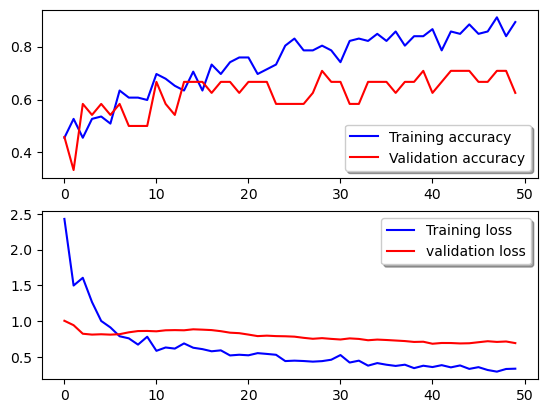

In [212]:
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[0].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['loss'], color='b', label="Training loss")
ax[1].plot(history.history['val_loss'], color='r', label="validation loss")
legend = ax[1].legend(loc='best', shadow=True) 

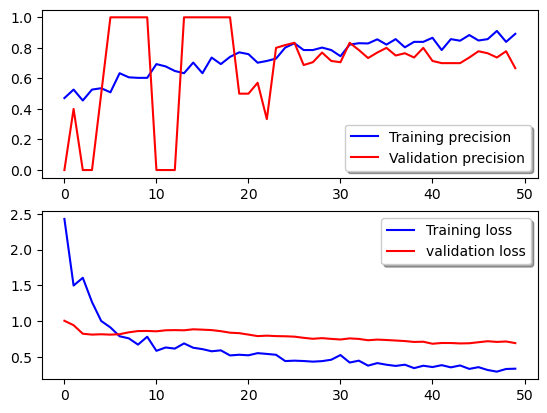

In [221]:
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['precision'], color='b', label="Training precision")
ax[0].plot(history.history['val_precision'], color='r',label="Validation precision")
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['loss'], color='b', label="Training loss")
ax[1].plot(history.history['val_loss'], color='r', label="validation loss")
legend = ax[1].legend(loc='best', shadow=True)

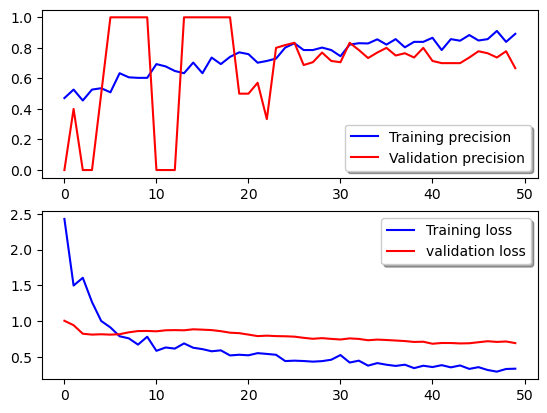

In [222]:
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['precision'], color='b', label="Training precision")
ax[0].plot(history.history['val_precision'], color='r',label="Validation precision")
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['loss'], color='b', label="Training loss")
ax[1].plot(history.history['val_loss'], color='r', label="validation loss")
legend = ax[1].legend(loc='best', shadow=True)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step


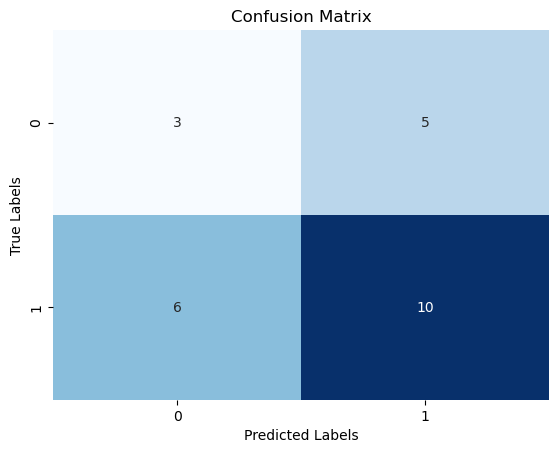

In [223]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
y_pred = model.predict(X_test)

y_pred_classes = np.argmax(y_pred, axis=1)

# Create a confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)

# Plot the confusion matrix using seaborn
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

HYBRID MODEL LSTM WITH MOBILENET

In [226]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, LSTM, Reshape, TimeDistributed
from tensorflow.keras.models import Model

# Define parameters
img_height, img_width = 224, 224
batch_size = 32
num_classes = 2
lstm_timesteps = 10  # Number of time steps for LSTM

# Prepare data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    r'C:\Users\Maaruboina Vamsi\dataset\Training',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

validation_generator = test_datagen.flow_from_directory(
    r'C:\Users\Maaruboina Vamsi\dataset\Training',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Load pre-trained MobileNet model
base_model = MobileNet(weights='imagenet', include_top=False)

# Add LSTM layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Reshape((1, -1))(x)
x = LSTM(128, return_sequences=True)(x)
x = LSTM(128)(x)
predictions = Dense(num_classes, activation='softmax')(x)

# Combine base model with LSTM layers
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze layers in base model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy','precision','recall'])

# Train the model
hist=model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size
)

# Save the trained model
model.save('hybrid_model.h5')

Found 19 images belonging to 2 classes.
Found 19 images belonging to 2 classes.


C:\Users\Maaruboina Vamsi\AppData\Local\Temp\ipykernel_24772\253052842.py:41: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNet(weights='imagenet', include_top=False)
C:\Anaconda\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 20s 20s/step - accuracy: 0.6842 - loss: 0.6923 - precision: 0.6842 - recall: 0.6842 - val_accuracy: 0.8421 - val_loss: 0.6482 - val_precision: 0.8421 - val_recall: 0.8421
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.7368 - loss: 0.6482 - precision: 0.7368 - recall: 0.7368 - val_accuracy: 0.9474 - val_loss: 0.5990 - val_precision: 0.9474 - val_recall: 0.9474
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.9474 - loss: 0.6002 - precision: 0.9474 - recall: 0.9474 - val_accuracy: 1.0000 - val_loss: 0.5397 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.5341 - precision: 1.0000 - recall: 1.0000 - val_accuracy: 1.0000 - val_loss: 0.4710 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.4705 - precision: 1.0000 - recall: 1.0000 - val_accuracy: 0.9474 - val_loss: 0.3978 - val_precision: 0

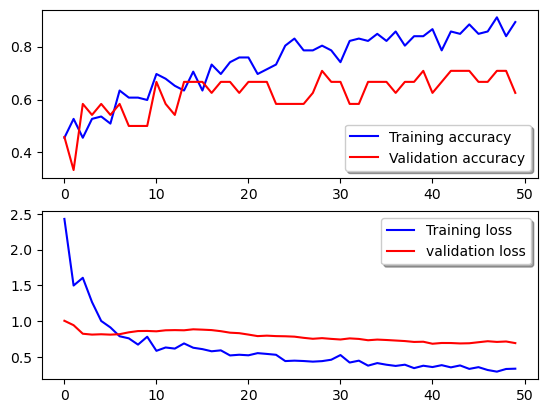

In [229]:
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[0].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['loss'], color='b', label="Training loss")
ax[1].plot(history.history['val_loss'], color='r', label="validation loss")
legend = ax[1].legend(loc='best', shadow=True) 

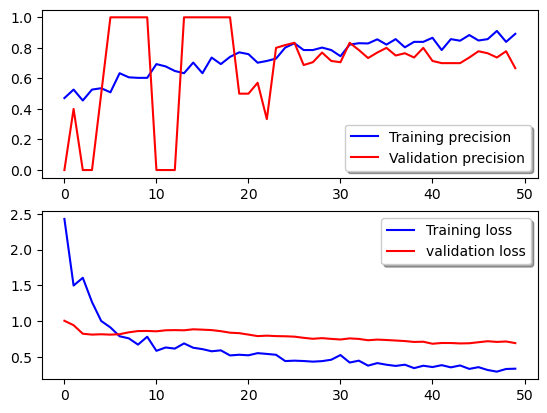

In [231]:
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['precision'], color='b', label="Training precision")
ax[0].plot(history.history['val_precision'], color='r',label="Validation precision")
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['loss'], color='b', label="Training loss")
ax[1].plot(history.history['val_loss'], color='r', label="validation loss")
legend = ax[1].legend(loc='best', shadow=True)

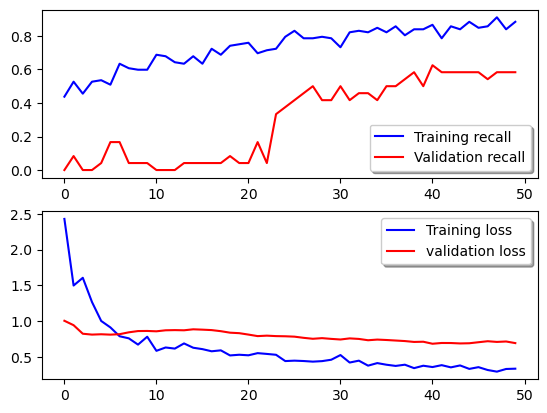

In [233]:
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['recall'], color='b', label="Training recall")
ax[0].plot(history.history['val_recall'], color='r',label="Validation recall")
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['loss'], color='b', label="Training loss")
ax[1].plot(history.history['val_loss'], color='r', label="validation loss")
legend = ax[1].legend(loc='best', shadow=True)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Accuracy: 1.0


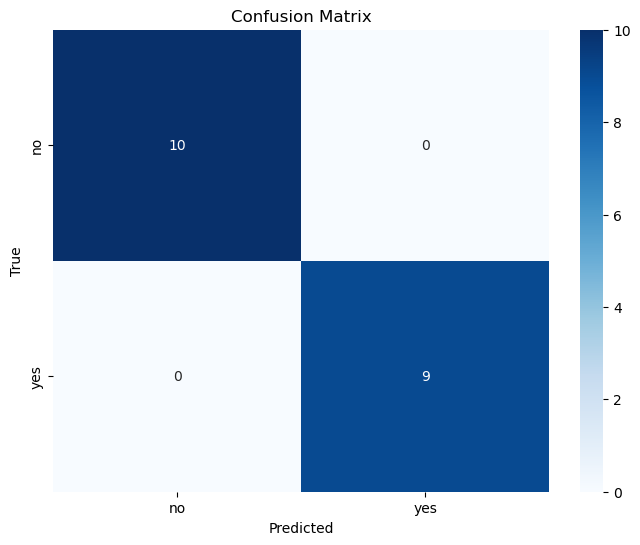

Classification Report:
              precision    recall  f1-score   support

          no       1.00      1.00      1.00        10
         yes       1.00      1.00      1.00         9

    accuracy                           1.00        19
   macro avg       1.00      1.00      1.00        19
weighted avg       1.00      1.00      1.00        19



In [234]:
from sklearn.metrics import confusion_matrix, classification_report
# Make predictions
predictions = model.predict(validation_generator)
predicted_classes = np.argmax(predictions, axis=1)

true_classes = validation_generator.classes
class_labels = list(validation_generator.class_indices.keys())

# Calculate accuracy
accuracy = np.mean(predicted_classes == true_classes)
print(f"Accuracy: {accuracy}")

# Generate confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification report
print("Classification Report:")
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

SVM

In [236]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
import cv2
import os, glob
import tensorflow as tf
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.models import Model, Sequential, load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, AveragePooling2D,GlobalAveragePooling2D,Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [263]:
train_dir= r'C:\Users\Maaruboina Vamsi\dataset\Training'
test_dir= r'C:\Users\Maaruboina Vamsi\dataset\Training'

In [265]:
data_dir = r"dataset\Training"
Brain=[]
for file in os.listdir(data_dir):
    Brain+=[file]
print(Brain)
print(len(Brain))

['no', 'yes']
2


In [267]:
precision=tf.keras.metrics.Precision()
recall=tf.keras.metrics.Recall()

In [269]:
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [271]:
img_height,img_width=256,256
batch_size=20

train_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(train_dir,
                                                target_size=(img_height,img_width),
                                                batch_size=batch_size,
                                                class_mode='categorical')
test_generator = train_datagen.flow_from_directory(test_dir,
                                                target_size=(img_height,img_width),
                                                batch_size=batch_size,
                                                class_mode='categorical')

Found 19 images belonging to 2 classes.
Found 19 images belonging to 2 classes.


In [273]:
from tensorflow import keras
from tensorflow.keras.regularizers import l2

In [275]:
model = Sequential()
model.add(Conv2D(filters = 32, padding = "same",activation = "relu",kernel_size=3, strides = 2,input_shape=(img_height,img_width,3)))
model.add(MaxPool2D(pool_size=(2,2),strides = 2))

model.add(Conv2D(filters = 32, padding = "same",activation = "relu",kernel_size=3))
model.add(MaxPool2D(pool_size=(2,2),strides = 2))

model.add(Flatten())
model.add(Dense(128,activation="relu"))


model.add(Dense(2,kernel_regularizer=l2(0.01),activation = "softmax"))
model.summary()

C:\Anaconda\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)                    │ (None, 128, 128, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 64, 64, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 32768)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 128)                 │       4,194,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,204,834 (16.04 MB)

 Trainable params: 4,204,834 (16.04 MB)

 Non-trainable params: 0 (0.00 B)

In [277]:
model.compile(optimizer="adam",loss="squared_hinge",metrics=['accuracy',precision,recall])
hist=model.fit(train_generator,epochs=10,validation_data=test_generator)

C:\Anaconda\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step - accuracy: 0.3684 - loss: 1.3003 - precision_6: 0.3684 - recall_6: 0.3684 - val_accuracy: 0.4737 - val_loss: 1.2930 - val_precision_6: 0.4737 - val_recall_6: 0.4737
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 638ms/step - accuracy: 0.4737 - loss: 1.2930 - precision_6: 0.4737 - recall_6: 0.4737 - val_accuracy: 0.5789 - val_loss: 1.2173 - val_precision_6: 0.5789 - val_recall_6: 0.5789
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.5789 - loss: 1.2173 - precision_6: 0.5789 - recall_6: 0.5789 - val_accuracy: 0.9474 - val_loss: 0.8451 - val_precision_6: 0.9474 - val_recall_6: 0.9474
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 632ms/step - accuracy: 0.9474 - loss: 0.8451 - precision_6: 0.9474 - recall_6: 0.9474 - val_accuracy: 0.7368 - val_loss: 0.8476 - val_precision_6: 0.7368 - val_recall_6: 0.7368
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 577ms/step - accuracy: 0.7368 - loss: 0.8476 - precision_6: 0.7368 - recall_6: 0.7368 - val_accuracy:

In [279]:
model.evaluate(test_generator)
model.save("models/SVM.h5")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step - accuracy: 1.0000 - loss: 0.5498 - precision_6: 1.0000 - recall_6: 1.0000


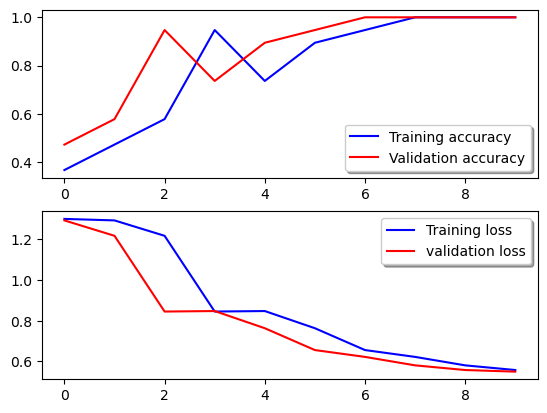

In [281]:
fig, ax = plt.subplots(2,1)
ax[0].plot(hist.history['accuracy'], color='b', label="Training accuracy")
ax[0].plot(hist.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(hist.history['loss'], color='b', label="Training loss")
ax[1].plot(hist.history['val_loss'], color='r', label="validation loss")
legend = ax[1].legend(loc='best', shadow=True)

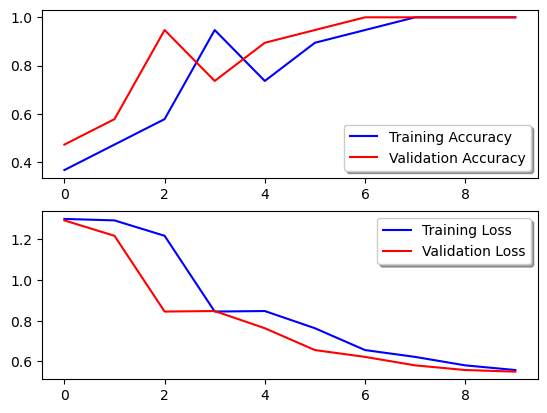

In [285]:
fig, ax = plt.subplots(2, 1)

ax[0].plot(hist.history['accuracy'], color='b', label="Training Accuracy")  # Corrected name
ax[0].plot(hist.history['val_accuracy'], color='r', label="Validation Accuracy") # Corrected name

legend = ax[0].legend(loc='best', shadow=True)  # Corrected placement of legend

ax[1].plot(hist.history['loss'], color='b', label="Training Loss")
ax[1].plot(hist.history['val_loss'], color='r', label="Validation Loss")

legend = ax[1].legend(loc='best', shadow=True)  # Corrected placement of legend

plt.show() # Add plt.show() to actually display the plot

In [291]:
from tensorflow.keras.metrics import Recall

In [299]:
import tensorflow as tf  # Or from tensorflow import keras
from tensorflow.keras.optimizers import Adam, RMSprop  # Import Adam and RMSprop
from tensorflow.keras.metrics import Recall

# ... (your model definition) ...

# Option 1: Using Adam optimizer
model.compile(optimizer=Adam(), loss='...', metrics=['accuracy', Recall()])

# Option 2: Using RMSprop optimizer
# model.compile(optimizer=RMSprop(), loss='...', metrics=['accuracy', Recall()])

# Option 3: Using SGD optimizer
# from tensorflow.keras.optimizers import SGD
# model.compile(optimizer=SGD(), loss='...', metrics=['accuracy', Recall()])

# ... (rest of your code)

In [313]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Recall
import numpy as np
import matplotlib.pyplot as plt

# Load MNIST data (or your dataset)
(X_train, y_train), (X_val, y_val) = tf.keras.datasets.mnist.load_data()

# Verify Shapes
print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)

# Correct Reshaping
num_train_samples = X_train.shape[0]  # Get the number of training samples
num_val_samples = X_val.shape[0]      # Get the number of validation samples

X_train = X_train.reshape(num_train_samples, 784)  # Reshape using the correct number of samples
X_val = X_val.reshape(num_val_samples, 784)

y_train = np.array(y_train).astype(int)
y_val = np.array(y_val).astype(int)

# ... (rest of your code)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
X_train shape: (60000, 28, 28)
X_val shape: (10000, 28, 28)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step
Accuracy: 0.47368421052631576


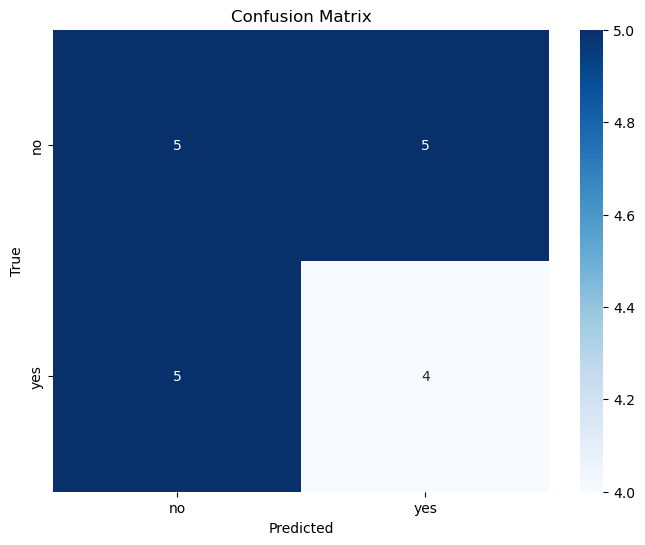

Classification Report:
              precision    recall  f1-score   support

          no       0.50      0.50      0.50        10
         yes       0.44      0.44      0.44         9

    accuracy                           0.47        19
   macro avg       0.47      0.47      0.47        19
weighted avg       0.47      0.47      0.47        19



In [317]:
from sklearn.metrics import confusion_matrix, classification_report
# Make predictions
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)

true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Calculate accuracy
accuracy = np.mean(predicted_classes == true_classes)
print(f"Accuracy: {accuracy}")

# Generate confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification report
print("Classification Report:")
print(classification_report(true_classes, predicted_classes, target_names=class_labels))